In [ ]:
import matplotlib.pylab as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
keras=tf.keras    
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# WOODLAND

In [ ]:
#path = "data/woodlands_query_data_all.csv"
#path = "woodlands_query_data_with_features.csv"
path = "woodlands_query_data_with_2_features.csv"
dataset = pd.read_csv(path)
dataset = dataset[['date','sales','weather_good','holiday_or_not']]
# all_data = pd.read_csv(path)
# dataset = all_data.iloc[:-20,0:]
# test=all_data.iloc[-20:,0:]
dataset['date'] = pd.to_datetime(dataset['date'])
# print("train","test","all")
print(len(dataset))#,len(test),len(all_data))
dataset.head()

429


,date,sales,weather_good,holiday_or_not
0,2020-07-01,34,3,1
1,2020-07-02,36,1,1
2,2020-07-03,20,2,0
3,2020-07-04,17,0,0
4,2020-07-05,26,0,0


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'],infer_datetime_format=True) #convert from string to datetime
print(len(dataset))
indexedDataset = dataset.set_index(['date'])
print(len(indexedDataset))
indexedDataset = indexedDataset.resample('1D').mean().interpolate()
print(len(indexedDataset))
indexedDataset.head(5)

429
429
615


,sales,weather_good,holiday_or_not
date,,,
2020-07-01,34.0,3.0,1.0
2020-07-02,36.0,1.0,1.0
2020-07-03,20.0,2.0,0.0
2020-07-04,17.0,0.0,0.0
2020-07-05,26.0,0.0,0.0


In [ ]:
# test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True) #convert from string to datetime
# testindexedDataset = test.set_index(['date'])
# testindexedDataset = testindexedDataset.resample('1D').mean().interpolate()
# testindexedDataset.head(5)

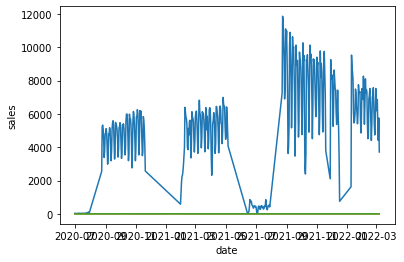

In [ ]:
## plot graph
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(indexedDataset)

In [ ]:
print(len(indexedDataset))

615


In [ ]:
indexedDataset

,sales,weather_good,holiday_or_not
date,,,
2020-07-01,34.0,3.0,1.0
2020-07-02,36.0,1.0,1.0
2020-07-03,20.0,2.0,0.0
2020-07-04,17.0,0.0,0.0
2020-07-05,26.0,0.0,0.0
...,...,...,...
2022-03-03,6868.0,0.0,1.0
2022-03-04,5374.0,0.0,1.0
2022-03-05,4410.0,4.0,0.0


In [ ]:
scaler = MinMaxScaler()
scaler.fit(indexedDataset)
scaled_data = scaler.transform(indexedDataset)
# scaled_train_data = scaler.transform(indexedDataset)
# scaled_test_data = scaler.transform(testindexedDataset)

In [ ]:
print(len(scaled_data))

615


In [ ]:
scaled_data

array([[1.43472023e-03, 3.00000000e-01, 1.00000000e+00],
       [1.60351084e-03, 1.00000000e-01, 1.00000000e+00],
       [2.53185923e-04, 2.00000000e-01, 0.00000000e+00],
       ...,
       [3.70748586e-01, 4.00000000e-01, 0.00000000e+00],
       [4.84513461e-01, 4.00000000e-01, 0.00000000e+00],
       [3.12178243e-01, 3.00000000e-01, 1.00000000e+00]])

In [ ]:
reframed = series_to_supervised(scaled_data, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.001435,0.3,1.0,0.001604,0.1,1.0
2,0.001604,0.1,1.0,0.000253,0.2,0.0
3,0.000253,0.2,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.000760,0.0,0.0
5,0.000760,0.0,0.0,0.001772,0.6,1.0


In [ ]:
#reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
#reframed.drop(reframed.columns[['var2(t)','var3(t)']], axis=1, inplace=True)
reframed.drop(['var2(t)', 'var3(t)'], axis=1, inplace=True)
reframed.head()

# reframed_tr = series_to_supervised(scaled_train_data, 1, 1)
# reframed_te = series_to_supervised(scaled_test_data, 1, 1)
# reframed_tr.drop(reframed_tr.columns[[3]], axis=1, inplace=True)
# reframed_te.drop(reframed_te.columns[[3]], axis=1, inplace=True)

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.001435,0.3,1.0,0.001604
2,0.001604,0.1,1.0,0.000253
3,0.000253,0.2,0.0,0.000000
4,0.000000,0.0,0.0,0.000760
5,0.000760,0.0,0.0,0.001772


In [ ]:
print(len(reframed))

614


In [ ]:
# split into train and test sets
values = reframed.values
train = values[:-60, :]
test = values[-60:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(554, 1, 3) (554,) (60, 1, 3) (60,)


# change batch size (10,20,30,40)
# change middle layer neurons (50,100,150)
# use mae instead of mse

Epoch 1/50
12/12 - 2s - loss: 0.2801 - val_loss: 0.4273 - 2s/epoch - 154ms/step
Epoch 2/50
12/12 - 0s - loss: 0.2235 - val_loss: 0.3440 - 104ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 0.1885 - val_loss: 0.2736 - 107ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 0.1727 - val_loss: 0.2303 - 108ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 0.1624 - val_loss: 0.2059 - 115ms/epoch - 10ms/step
Epoch 6/50
12/12 - 0s - loss: 0.1533 - val_loss: 0.1929 - 106ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 0.1435 - val_loss: 0.1837 - 115ms/epoch - 10ms/step
Epoch 8/50
12/12 - 0s - loss: 0.1319 - val_loss: 0.1694 - 104ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 0.1189 - val_loss: 0.1531 - 118ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 0.1043 - val_loss: 0.1366 - 109ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0889 - val_loss: 0.1163 - 106ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0757 - val_loss: 0.1042 - 107ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s 

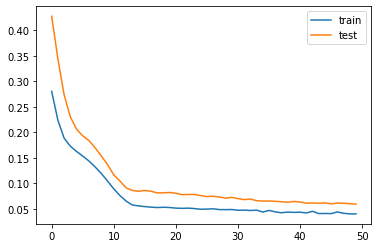

In [ ]:
# design network
from matplotlib import pyplot
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mae', optimizer='opt')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1245.916


In [ ]:
inv_yhat

array([1637.49409302, 1781.82957426, 1928.34809105, 2077.05388093,
       8571.94978368, 7989.48680055, 7694.22824049, 7303.33492559,
       5663.63863009, 6776.27485639, 6901.11186099, 7310.14393425,
       6819.8917796 , 6620.65923989, 5867.28350064, 5530.49747407,
       6682.4128027 , 7258.38106084, 7092.9258936 , 6677.17662489,
       6633.09216058, 6680.6980145 , 5242.39751911, 6064.98664421,
       7079.79519254, 6844.54080057, 6698.30566877, 6265.51728141,
       7495.24006516, 6381.48866153, 6651.75990427, 7979.33225989,
       7355.3831262 , 6613.54371637, 6813.85965192, 6675.41593009,
       5024.93899849, 5677.9406558 , 5844.51982856, 6292.46304506,
       6504.13768679, 6848.04524004, 6037.01398516, 5044.38185751,
       5530.39188889, 6777.75658029, 6407.30865401, 6599.02239835,
       6917.4051739 , 5762.70119569, 4859.58729768, 5949.38957947,
       7023.95228148, 6848.04524004, 6109.3281855 , 5651.03161743,
       6260.12855244, 4912.11539885, 5513.21575668, 7152.10091

In [ ]:
inv_y

array([1550.43478261, 1588.2173913 , 1626.        , 9534.        ,
       8848.        , 8502.        , 8048.        , 6092.        ,
       5462.        , 5574.        , 5994.        , 7496.        ,
       7270.        , 6432.        , 6058.        , 5412.        ,
       5946.        , 7752.        , 7334.        , 7284.        ,
       7338.        , 5738.        , 4856.        , 5780.        ,
       7524.        , 7358.        , 6874.        , 8270.        ,
       6980.        , 5384.        , 6560.        , 8108.        ,
       7262.        , 7462.        , 7332.        , 5456.        ,
       4516.        , 4668.        , 6904.        , 7140.        ,
       7528.        , 6620.        , 5496.        , 4408.        ,
       5500.        , 7032.        , 7108.        , 7578.        ,
       6316.        , 5316.        , 4742.        , 5728.        ,
       7528.        , 6700.        , 6192.        , 6868.        ,
       5374.        , 4410.        , 5758.        , 3716.     

In [ ]:
date_vals = pd.date_range(start="2022-01-07",end="2022-03-07")

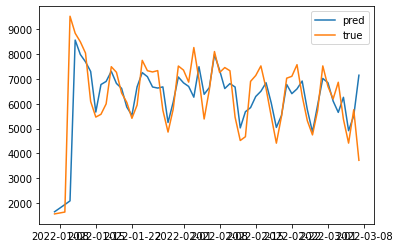

In [ ]:
pyplot.plot(date_vals,inv_yhat, label='pred')
pyplot.plot(date_vals,inv_y, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
print("pred",inv_yhat)
print("true",inv_y)

pred [2072.22468282 2227.07383561 2384.16464315 2543.56066844 8759.80242956
 8070.92793989 7735.18540573 7304.8879813  5567.06667429 7271.25609744
 7416.3633393  7957.4016161  6785.60095942 6574.22435749 5808.48279181
 5471.73419678 7257.84571922 7900.99299443 7034.9599787  6634.01029265
 6587.29855812 6637.74920893 5188.7274029  6545.81311381 7705.03818619
 6811.83834887 6656.44520283 6210.67937183 7514.9354105  6313.730515
 7222.19959486 8610.70343196 7361.58899271 6566.75641251 6757.73211992
 6632.14154077 4954.56770685 6056.15845126 6306.48574674 6238.07360768
 6454.00131965 6815.58715272 5979.2295779  4979.8470608  5976.80500299
 7367.03704715 6355.09307086 6523.37961614 6865.22984731 5703.36655775
 4815.85666734 6344.68427825 7642.81143224 6815.58715272 6052.03321326
 5591.20330694 6205.20094842 4867.77032629 5727.59606299 7489.70796633]
true [1550.43478261 1588.2173913  1626.         9534.         8848.
 8502.         8048.         6092.         5462.         5574.
 5994.       

In [ ]:
diff_pr_tr = inv_yhat-inv_y
diff_pr_tr

array([  521.78990021,   638.85644431,   758.16464315, -6990.43933156,
         -88.19757044,  -431.07206011,  -312.81459427,  1212.8879813 ,
         105.06667429,  1697.25609744,  1422.3633393 ,   461.4016161 ,
        -484.39904058,   142.22435749,  -249.51720819,    59.73419678,
        1311.84571922,   148.99299443,  -299.0400213 ,  -649.98970735,
        -750.70144188,   899.74920893,   332.7274029 ,   765.81311381,
         181.03818619,  -546.16165113,  -217.55479717, -2059.32062817,
         534.9354105 ,   929.730515  ,   662.19959486,   502.70343196,
          99.58899271,  -895.24358749,  -574.26788008,  1176.14154077,
         438.56770685,  1388.15845126,  -597.51425326,  -901.92639232,
       -1073.99868035,   195.58715272,   483.2295779 ,   571.8470608 ,
         476.80500299,   335.03704715,  -752.90692914, -1054.62038386,
         549.22984731,   387.36655775,    73.85666734,   616.68427825,
         114.81143224,   115.58715272,  -139.96678674, -1276.79669306,
      

In [ ]:
# from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# # design network
# model = Sequential()
# model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
# from keras.preprocessing.sequence import TimeseriesGenerator

# # n_input = 12
# # n_features= 2 # 2 or more
# n_input = 1
# n_features= 2 # 2 or more
# generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# lstm_model = Sequential()
# lstm_model.add(LSTM(200, activation='relu', input_shape=(1, 2)))
# lstm_model.add(Dense(1))
# lstm_model.compile(optimizer='adam', loss='mse')

# lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               162400    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 162,601
Trainable params: 162,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# lstm_model.fit_generator(generator,epochs=4)

Epoch 1/4
  1/594 [..............................] - ETA: 26s - loss: 0.0580

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


594/594 [==============================] - 5s 8ms/step - loss: 0.0511
Epoch 2/4
594/594 [==============================] - 3s 6ms/step - loss: 0.0507
Epoch 3/4
594/594 [==============================] - 3s 4ms/step - loss: 0.0505
Epoch 4/4
594/594 [==============================] - 3s 4ms/step - loss: 0.0503


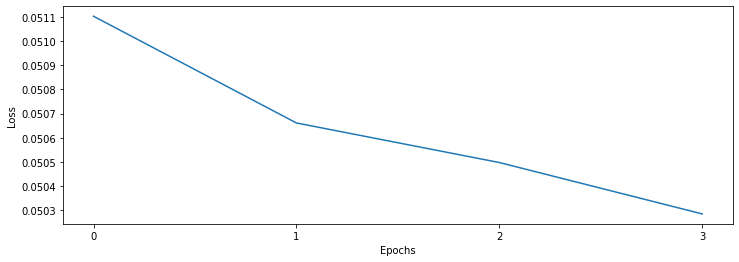

In [ ]:
# losses_lstm = lstm_model.history.history['loss']
# plt.figure(figsize=(12,4))
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.xticks(np.arange(0,21,1))
# plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
# scaled_train_data

array([[3.00000000e-01, 1.43472023e-03],
       [1.00000000e-01, 1.60351084e-03],
       [2.00000000e-01, 2.53185923e-04],
       ...,
       [0.00000000e+00, 3.92522576e-01],
       [0.00000000e+00, 5.81230484e-01],
       [0.00000000e+00, 6.01147776e-01]])

In [ ]:
# lstm_predictions_scaled = list()
# batch = scaled_train_data[-n_input:]
# #current_batch = batch.reshape((1, n_input, n_features))
# print(batch)

[[0.         0.60114778]]


In [ ]:

# for i in range(len(testindexedDataset)):   
#     lstm_pred = lstm_model.predict(current_batch)[0]
#     lstm_predictions_scaled.append(lstm_pred) 
#     current_batch[:,1:,:]
#     #current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

[array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32)]
[array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], dtype=float32), array([0.29948863], d

In [ ]:
# lstm_predictions_scaled = list()

# batch = scaled_train_data[-n_input:]
# current_batch = batch.reshape((1, n_input, n_features))

# for i in range(len(testindexedDataset)):   
#     lstm_pred = lstm_model.predict(current_batch)[0]
#     lstm_predictions_scaled.append(lstm_pred) 
#     current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

ValueError: ignored

In [ ]:
# lstm_predictions_scaled